<img src="計算流程.JPG" style="width:935px;height:500px;float:middle">
以上為此程式的計算流程<br>

### 改變initializer，在訓練的過程中即可降低loss

使用tf.contrib.layers.xavier_initializer() 或 tf.glorot_uniform_initializer()，都可以讓training loss下降

### 請解壓縮data.rar，取得本程式之數據

In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import cv2
import os

C:\Users\hong guo peng\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 超參數
EPOCHS = 50
LR = 1e-3
BS = 32
IMAGE_DIMS = [96 , 96 , 3]

## 讀取檔案之前，請直接解壓縮dataset.rar

label : 0 , class : black
label : 1 , class : blue
label : 2 , class : dress
label : 3 , class : jeans
label : 4 , class : red
label : 5 , class : shirt


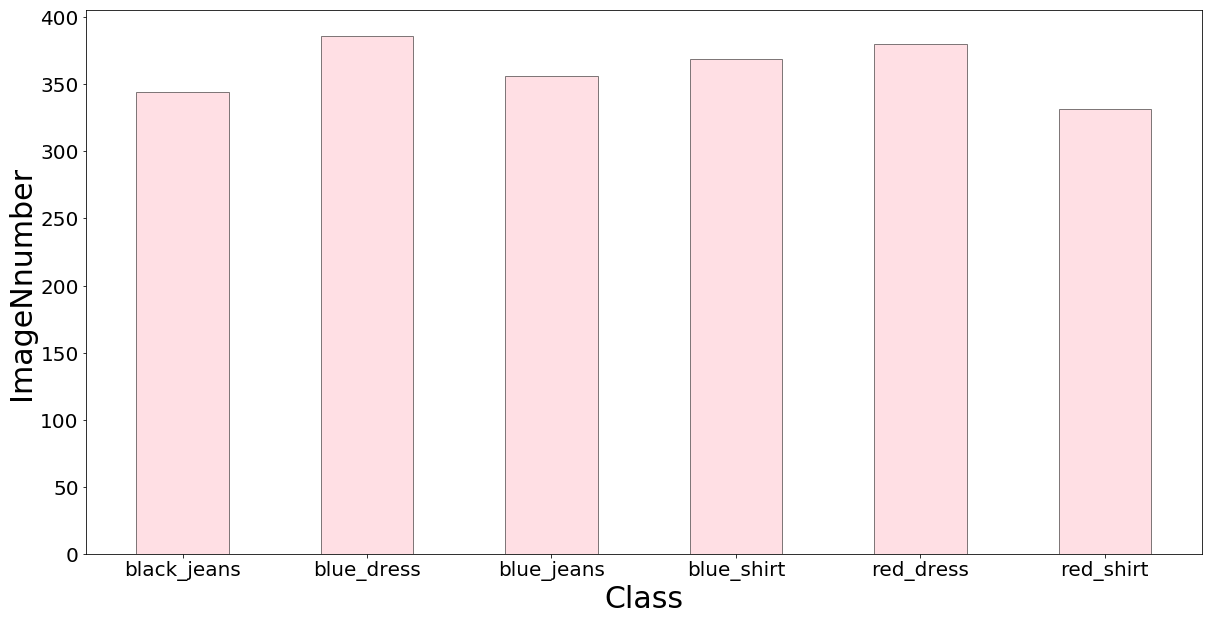

In [3]:
# 獲取數據路徑
image_types = ['.jpg' , '.jpeg' , '.png' , '.bmp' , '.tif' , '.tiff'] # 只要副檔名符合image_types中的任何一個都當作訓練資料
imagePaths = [] 
image_num = {}
for files in os.listdir('./dataset'):
    # 計算每個資料夾image的數目    
    image_num[files] = len(os.listdir('./dataset/{}'.format(files))) 
    for image in os.listdir('./dataset/{}'.format(files)):
        # os.path.splitext(image) => 獲取image的副檔名
        if os.path.splitext(image)[-1].lower() in image_types:
            imagePaths.append('./dataset/{}/{}'.format(files , image))
random.seed(42)
random.shuffle(imagePaths)

# 繪圖看一下每個資料夾的image的數目的分布情形
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.bar(image_num.keys() , image_num.values() , alpha = 0.5 , width = 0.5 , facecolor = 'pink' , edgecolor = 'black')
ax.set_xlabel('Class' , fontsize = 30)
ax.set_ylabel('ImageNnumber' , fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


# 獲取數據標簽
data , labels = [] , []
for imagePath in imagePaths:
    # 讀取image，並將image做resize
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1] , IMAGE_DIMS[0]))
    data.append(image)
    
    # 服裝顏色 => label[0]    服裝種類 => label[1]   
    label = imagePath.split('/')[-2].split('_')
    labels.append(label)

    
# 將讀取到的image做預處理    
data = np.array(data , dtype = 'float') / 255.0
data = data.astype('float32')
labels = np.array(labels)


# 制作標簽(以下為MultiLabel的示意說明)
#              blue  black  red  shirt  dress  jeans
# label_1 =>    1     0      0     1      0      0
# label_2 =>    0     1      0     0      1      0 
# label_3 =>    0     0      1     0      0      1 
# 每筆data的label在服裝顏色與服裝種類分別都會有1個1
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels).astype('float32')  
for i , label in enumerate(mlb.classes_):
    print('label : {} , class : {}'.format(i , label))

    
# 數據集切分
(trainX , testX , trainY , testY) = train_test_split(data ,
                                                     labels , 
                                                     test_size = 0.2 , 
                                                     random_state = 42)    

每個資料夾image的數目看起來還算均勻

In [4]:
def weight_variable(shape):
    # tf.contrib.layers.xavier_initializer() 與 tf.glorot_uniform_initializer() 效果都差不多 !!
    # 不過使用tf.truncated_normal(shape , stddev = 0.0001)，根本train不起來
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape))

def bias_variable(shape):
    initializer = tf.constant(0.0001 , shape = shape)
    return tf.Variable(initializer)

def conv2d(x , W):
    # stride [1, x_movement , y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x , W , strides = [1 , 1 , 1 , 1] , padding = 'SAME') 

def max_pool(x , k , s):
    # 不需要跟tf.nn.conv2d一樣要輸入W
    # ksize = [1 , *2* , *2* , 1] 輸入 2 , 2 代表每2x2個pixel做一次選取pixel最大的動作
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x , ksize = [1 , k , k , 1] , strides = [1 , s , s , 1] , padding = 'SAME')

In [5]:
# input layer
xs = tf.placeholder(tf.float32 , [None , IMAGE_DIMS[0] , IMAGE_DIMS[0] , IMAGE_DIMS[2]])
ys = tf.placeholder(tf.int32 , [None , 6])
on_train = tf.placeholder(tf.bool) # train/test selector for dropout
lr = tf.placeholder(tf.float32)


with tf.variable_scope('classfication_for_color_and_clothing'):
    # conv1 layer 
    conv_w_1 = weight_variable([3 , 3 , 3 , 32]) 
    conv_b_1 = bias_variable([32])
    conv_output_1 = tf.nn.relu(conv2d(xs , conv_w_1) + conv_b_1) 
    conv_pooling_1 = max_pool(conv_output_1 , k = 3 , s = 3)
    conv_dropout_1 = tf.cond(on_train , 
                             lambda : tf.nn.dropout(conv_pooling_1 , keep_prob = 0.9) , 
                             lambda : tf.nn.dropout(conv_pooling_1 , keep_prob = 1))


    # conv2 layer 
    conv_w_2 = weight_variable([3 , 3 , 32 , 64]) 
    conv_b_2 = bias_variable([64])
    conv_output_2 = tf.nn.relu(conv2d(conv_dropout_1 , conv_w_2) + conv_b_2)


    # conv3 layer 
    conv_w_3 = weight_variable([3 , 3 , 64 , 64]) 
    conv_b_3 = bias_variable([64])
    conv_output_3 = tf.nn.relu(conv2d(conv_output_2 , conv_w_3) + conv_b_3) 
    conv_pooling_3 = max_pool(conv_output_3 , k = 2 , s = 2)
    conv_dropout_3 = tf.cond(on_train ,
                             lambda : tf.nn.dropout(conv_pooling_3 , keep_prob = 0.9) , 
                             lambda : tf.nn.dropout(conv_pooling_3 , keep_prob = 1))

    # conv4 layer 
    conv_w_4 = weight_variable([3 , 3 , 64 , 128]) 
    conv_b_4 = bias_variable([128])
    conv_output_4 = tf.nn.relu(conv2d(conv_dropout_3 , conv_w_4) + conv_b_4) 


    # conv5 layer 
    conv_w_5 = weight_variable([3 , 3 , 128 , 128]) 
    conv_b_5 = bias_variable([128])
    conv_output_5 = tf.nn.relu(conv2d(conv_output_4 , conv_w_5) + conv_b_5) 
    conv_pooling_5 = max_pool(conv_output_5 , k = 2 , s = 2)
    conv_dropout_5 = tf.cond(on_train , 
                             lambda : tf.nn.dropout(conv_pooling_5 , keep_prob = 0.9) , 
                             lambda : tf.nn.dropout(conv_pooling_5 , keep_prob = 1))
    conv_dropout_5_flatten = tf.layers.flatten(conv_dropout_5)


    # fully connected layer 1
    fc_w_1 = weight_variable([conv_dropout_5_flatten.shape[1].value , 1024])
    fc_b_1 = bias_variable([1024])
    fc_output_1 = tf.nn.relu(tf.matmul(conv_dropout_5_flatten , fc_w_1) + fc_b_1)
    fc_dropout_1 = tf.cond(on_train , 
                           lambda : tf.nn.dropout(fc_output_1 , keep_prob = 0.75) , 
                           lambda : tf.nn.dropout(fc_output_1 , keep_prob = 1))


    # fully connected layer 2
    fc_w_2 = weight_variable([1024 , 6])
    fc_b_2 = bias_variable([6])
    prediction = tf.nn.sigmoid(tf.matmul(fc_dropout_1 , fc_w_2) + fc_b_2) # prediction => (None , 6)


    # 因為是輸出經過的是sigmoid，因此cross entropy一定要寫成以下的寫法
    ys_ = tf.cast(ys , tf.float32)
    cross_entropy = (ys_ * tf.log(prediction + 1e-9)) + ((1 - ys_) * tf.log(1 - prediction + 1e-9)) 
    cross_entropy = -tf.reduce_mean(tf.reduce_sum(cross_entropy , axis = 1))

    # 一筆data中只要有一個預測錯誤，這一筆data就當作預測錯誤
    correct = tf.equal(tf.cast(tf.greater_equal(prediction , 0.5) , tf.int32) , tf.cast(ys , tf.int32))
    accuracy = tf.reduce_mean(tf.reduce_min(tf.cast(correct , tf.float32) , 1))
    train_op = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy) 

In [6]:
# 數據增強
aug = ImageDataGenerator(rotation_range = 25, 
                         width_shift_range = 0.1,
                         height_shift_range = 0.1 ,
                         shear_range = 0.2 ,
                         zoom_range = 0.2,
                         horizontal_flip = True ,
                         fill_mode = 'nearest')

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batches = 0
learning_rate = LR
train_loss_mean_record = []
val_loss_record = []
for epoch_i in range(0 , EPOCHS):
    train_loss_temp = []
    batches = 0
    for batch_i , (x_batch , y_batch) in enumerate(aug.flow(trainX , trainY , shuffle = True , batch_size = 32)):
        feed_dict = {xs : x_batch , ys : y_batch , 
                     on_train : True , 
                     lr : learning_rate}
        train_loss , train_acc , _ = sess.run([cross_entropy , accuracy , train_op] , feed_dict)
        train_loss_temp.append(train_loss)
        
        batches += 1
        if batches >= len(trainX) / 32: break
    
        if batch_i % 5 == 0: 
            print('=' * 30)
            print('epoch_i : {}'.format(epoch_i))
            print('batch_i : {}'.format(batch_i))
            print('train_loss : {:.2f}'.format(train_loss))
            print('train_accuracy : {:.2%}\n'.format(train_acc))
               
    feed_dict = {xs : testX , ys : testY , on_train : False}
    val_loss , val_acc = sess.run([cross_entropy , accuracy] , feed_dict)    
    prediction_value = sess.run(tf.cast(tf.greater_equal(prediction , 0.5) , tf.int32) , feed_dict)
    random_index = np.random.choice(len(testX) , 3 , replace = False) # 隨機從testX選3筆image觀看預測結果
    
    print('*' * 30) 
    print('epoch_i : {}'.format(epoch_i))               
    print('train_loss_batch_mean : {:.2f}'.format(np.array(train_loss_temp).mean()))
    print('val_loss : {:.2f}'.format(val_loss))
    print('val_accuracy : {:.2%}'.format(val_acc))
    print('prediction : \n{}'.format(list(prediction_value[random_index])))
    print('target : \n{}'.format(list(testY[random_index].astype(np.int32))))
    print('*' * 30 , '\n')  
    
    train_loss_mean_record.append(np.array(train_loss_temp).mean())    
    val_loss_record.append(val_loss)

epoch_i : 0
batch_i : 0
train_loss : 4.14
train_accuracy : 0.00%

epoch_i : 0
batch_i : 5
train_loss : 3.85
train_accuracy : 3.12%

epoch_i : 0
batch_i : 10
train_loss : 2.94
train_accuracy : 0.00%

epoch_i : 0
batch_i : 15
train_loss : 2.61
train_accuracy : 25.00%

epoch_i : 0
batch_i : 20
train_loss : 2.58
train_accuracy : 37.50%

epoch_i : 0
batch_i : 25
train_loss : 2.34
train_accuracy : 31.25%

epoch_i : 0
batch_i : 30
train_loss : 1.90
train_accuracy : 18.75%

epoch_i : 0
batch_i : 35
train_loss : 1.64
train_accuracy : 50.00%

epoch_i : 0
batch_i : 40
train_loss : 1.67
train_accuracy : 50.00%

epoch_i : 0
batch_i : 45
train_loss : 1.40
train_accuracy : 59.38%

epoch_i : 0
batch_i : 50
train_loss : 1.03
train_accuracy : 81.25%

******************************
epoch_i : 0
train_loss_batch_mean : 2.34
val_loss : 1.02
val_accuracy : 71.82%
prediction : 
[array([0, 1, 0, 0, 0, 1]), array([0, 0, 0, 0, 1, 1]), array([0, 0, 1, 0, 1, 0])]
target : 
[array([0, 1, 0, 0, 0, 1]), array([0, 0, 

epoch_i : 6
batch_i : 0
train_loss : 0.63
train_accuracy : 90.62%

epoch_i : 6
batch_i : 5
train_loss : 0.75
train_accuracy : 84.38%

epoch_i : 6
batch_i : 10
train_loss : 0.85
train_accuracy : 68.75%

epoch_i : 6
batch_i : 15
train_loss : 1.08
train_accuracy : 87.50%

epoch_i : 6
batch_i : 20
train_loss : 0.46
train_accuracy : 87.50%

epoch_i : 6
batch_i : 25
train_loss : 0.58
train_accuracy : 87.50%

epoch_i : 6
batch_i : 30
train_loss : 0.60
train_accuracy : 84.38%

epoch_i : 6
batch_i : 35
train_loss : 0.46
train_accuracy : 90.62%

epoch_i : 6
batch_i : 40
train_loss : 0.53
train_accuracy : 93.75%

epoch_i : 6
batch_i : 45
train_loss : 0.58
train_accuracy : 84.38%

epoch_i : 6
batch_i : 50
train_loss : 0.62
train_accuracy : 87.50%

******************************
epoch_i : 6
train_loss_batch_mean : 0.60
val_loss : 0.40
val_accuracy : 91.45%
prediction : 
[array([0, 1, 0, 0, 0, 1]), array([0, 1, 1, 0, 0, 0]), array([0, 1, 0, 1, 0, 0])]
target : 
[array([0, 1, 0, 0, 0, 1]), array([0, 

******************************
epoch_i : 11
train_loss_batch_mean : 0.35
val_loss : 0.32
val_accuracy : 93.53%
prediction : 
[array([1, 0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0, 1]), array([0, 1, 0, 1, 0, 0])]
target : 
[array([1, 0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0, 1]), array([0, 1, 0, 1, 0, 0])]
****************************** 

epoch_i : 12
batch_i : 0
train_loss : 0.22
train_accuracy : 93.75%

epoch_i : 12
batch_i : 5
train_loss : 0.71
train_accuracy : 84.38%

epoch_i : 12
batch_i : 10
train_loss : 0.12
train_accuracy : 100.00%

epoch_i : 12
batch_i : 15
train_loss : 0.26
train_accuracy : 93.75%

epoch_i : 12
batch_i : 20
train_loss : 0.25
train_accuracy : 96.88%

epoch_i : 12
batch_i : 25
train_loss : 0.40
train_accuracy : 93.75%

epoch_i : 12
batch_i : 30
train_loss : 0.23
train_accuracy : 93.75%

epoch_i : 12
batch_i : 35
train_loss : 0.38
train_accuracy : 87.50%

epoch_i : 12
batch_i : 40
train_loss : 0.11
train_accuracy : 96.88%

epoch_i : 12
batch_i : 45
train_loss : 0.72
trai

epoch_i : 17
batch_i : 35
train_loss : 0.23
train_accuracy : 93.75%

epoch_i : 17
batch_i : 40
train_loss : 0.74
train_accuracy : 93.75%

epoch_i : 17
batch_i : 45
train_loss : 0.37
train_accuracy : 87.50%

epoch_i : 17
batch_i : 50
train_loss : 0.22
train_accuracy : 90.62%

******************************
epoch_i : 17
train_loss_batch_mean : 0.28
val_loss : 0.24
val_accuracy : 94.69%
prediction : 
[array([0, 1, 0, 0, 0, 1]), array([0, 0, 1, 0, 1, 0]), array([0, 0, 0, 0, 1, 1])]
target : 
[array([0, 1, 0, 0, 0, 1]), array([0, 0, 1, 0, 1, 0]), array([0, 0, 0, 0, 1, 1])]
****************************** 

epoch_i : 18
batch_i : 0
train_loss : 0.13
train_accuracy : 100.00%

epoch_i : 18
batch_i : 5
train_loss : 1.24
train_accuracy : 81.25%

epoch_i : 18
batch_i : 10
train_loss : 0.85
train_accuracy : 81.25%

epoch_i : 18
batch_i : 15
train_loss : 0.21
train_accuracy : 93.75%

epoch_i : 18
batch_i : 20
train_loss : 0.45
train_accuracy : 87.50%

epoch_i : 18
batch_i : 25
train_loss : 0.57
trai

epoch_i : 23
batch_i : 20
train_loss : 0.10
train_accuracy : 96.88%

epoch_i : 23
batch_i : 25
train_loss : 0.10
train_accuracy : 96.88%

epoch_i : 23
batch_i : 30
train_loss : 0.43
train_accuracy : 90.62%

epoch_i : 23
batch_i : 35
train_loss : 0.18
train_accuracy : 96.88%

epoch_i : 23
batch_i : 40
train_loss : 0.14
train_accuracy : 96.88%

epoch_i : 23
batch_i : 45
train_loss : 0.05
train_accuracy : 100.00%

epoch_i : 23
batch_i : 50
train_loss : 0.05
train_accuracy : 100.00%

******************************
epoch_i : 23
train_loss_batch_mean : 0.23
val_loss : 0.42
val_accuracy : 92.38%
prediction : 
[array([0, 1, 0, 1, 0, 0]), array([0, 0, 0, 0, 1, 1]), array([0, 1, 0, 0, 0, 1])]
target : 
[array([0, 1, 0, 1, 0, 0]), array([0, 0, 0, 0, 1, 1]), array([0, 1, 0, 0, 0, 1])]
****************************** 

epoch_i : 24
batch_i : 0
train_loss : 0.08
train_accuracy : 100.00%

epoch_i : 24
batch_i : 5
train_loss : 0.18
train_accuracy : 93.75%

epoch_i : 24
batch_i : 10
train_loss : 0.17
tr

epoch_i : 29
batch_i : 0
train_loss : 0.22
train_accuracy : 93.75%

epoch_i : 29
batch_i : 5
train_loss : 0.26
train_accuracy : 93.75%

epoch_i : 29
batch_i : 10
train_loss : 0.03
train_accuracy : 100.00%

epoch_i : 29
batch_i : 15
train_loss : 0.35
train_accuracy : 90.62%

epoch_i : 29
batch_i : 20
train_loss : 0.32
train_accuracy : 90.62%

epoch_i : 29
batch_i : 25
train_loss : 0.07
train_accuracy : 100.00%

epoch_i : 29
batch_i : 30
train_loss : 0.19
train_accuracy : 96.88%

epoch_i : 29
batch_i : 35
train_loss : 0.22
train_accuracy : 96.88%

epoch_i : 29
batch_i : 40
train_loss : 0.08
train_accuracy : 100.00%

epoch_i : 29
batch_i : 45
train_loss : 0.43
train_accuracy : 93.75%

epoch_i : 29
batch_i : 50
train_loss : 0.23
train_accuracy : 90.62%

******************************
epoch_i : 29
train_loss_batch_mean : 0.25
val_loss : 0.26
val_accuracy : 94.69%
prediction : 
[array([0, 1, 0, 1, 0, 0]), array([1, 0, 0, 1, 0, 0]), array([0, 1, 0, 1, 0, 0])]
target : 
[array([0, 1, 0, 1, 0, 

******************************
epoch_i : 34
train_loss_batch_mean : 0.19
val_loss : 0.20
val_accuracy : 96.30%
prediction : 
[array([0, 1, 0, 1, 0, 0]), array([0, 1, 0, 0, 0, 1]), array([0, 1, 0, 0, 0, 1])]
target : 
[array([0, 1, 0, 1, 0, 0]), array([0, 1, 0, 0, 0, 1]), array([0, 1, 0, 0, 0, 1])]
****************************** 

epoch_i : 35
batch_i : 0
train_loss : 0.09
train_accuracy : 96.88%

epoch_i : 35
batch_i : 5
train_loss : 0.07
train_accuracy : 96.88%

epoch_i : 35
batch_i : 10
train_loss : 0.07
train_accuracy : 100.00%

epoch_i : 35
batch_i : 15
train_loss : 0.02
train_accuracy : 100.00%

epoch_i : 35
batch_i : 20
train_loss : 0.09
train_accuracy : 100.00%

epoch_i : 35
batch_i : 25
train_loss : 0.10
train_accuracy : 96.88%

epoch_i : 35
batch_i : 30
train_loss : 0.02
train_accuracy : 100.00%

epoch_i : 35
batch_i : 35
train_loss : 0.73
train_accuracy : 90.62%

epoch_i : 35
batch_i : 40
train_loss : 0.03
train_accuracy : 100.00%

epoch_i : 35
batch_i : 45
train_loss : 0.14


epoch_i : 40
batch_i : 35
train_loss : 0.35
train_accuracy : 90.62%

epoch_i : 40
batch_i : 40
train_loss : 0.13
train_accuracy : 96.88%

epoch_i : 40
batch_i : 45
train_loss : 0.22
train_accuracy : 96.88%

epoch_i : 40
batch_i : 50
train_loss : 0.21
train_accuracy : 96.88%

******************************
epoch_i : 40
train_loss_batch_mean : 0.18
val_loss : 0.26
val_accuracy : 95.84%
prediction : 
[array([0, 1, 0, 1, 0, 0]), array([0, 0, 1, 0, 1, 0]), array([0, 0, 1, 0, 1, 0])]
target : 
[array([1, 0, 0, 1, 0, 0]), array([0, 0, 1, 0, 1, 0]), array([0, 0, 1, 0, 1, 0])]
****************************** 

epoch_i : 41
batch_i : 0
train_loss : 0.05
train_accuracy : 100.00%

epoch_i : 41
batch_i : 5
train_loss : 0.61
train_accuracy : 93.75%

epoch_i : 41
batch_i : 10
train_loss : 0.32
train_accuracy : 96.88%

epoch_i : 41
batch_i : 15
train_loss : 0.14
train_accuracy : 96.88%

epoch_i : 41
batch_i : 20
train_loss : 0.16
train_accuracy : 96.88%

epoch_i : 41
batch_i : 25
train_loss : 0.18
trai

epoch_i : 46
batch_i : 15
train_loss : 0.32
train_accuracy : 93.75%

epoch_i : 46
batch_i : 20
train_loss : 0.03
train_accuracy : 100.00%

epoch_i : 46
batch_i : 25
train_loss : 0.15
train_accuracy : 93.75%

epoch_i : 46
batch_i : 30
train_loss : 0.09
train_accuracy : 100.00%

epoch_i : 46
batch_i : 35
train_loss : 0.02
train_accuracy : 100.00%

epoch_i : 46
batch_i : 40
train_loss : 0.11
train_accuracy : 96.88%

epoch_i : 46
batch_i : 45
train_loss : 0.39
train_accuracy : 93.75%

epoch_i : 46
batch_i : 50
train_loss : 0.51
train_accuracy : 81.25%

******************************
epoch_i : 46
train_loss_batch_mean : 0.18
val_loss : 0.27
val_accuracy : 95.38%
prediction : 
[array([0, 1, 0, 0, 0, 1]), array([0, 1, 0, 0, 0, 1]), array([0, 1, 0, 0, 0, 1])]
target : 
[array([0, 1, 0, 1, 0, 0]), array([0, 1, 0, 0, 0, 1]), array([0, 1, 0, 0, 0, 1])]
****************************** 

epoch_i : 47
batch_i : 0
train_loss : 0.08
train_accuracy : 96.88%

epoch_i : 47
batch_i : 5
train_loss : 0.12
tr